In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## Case 0 - Basic Usage

https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/#simple-usage

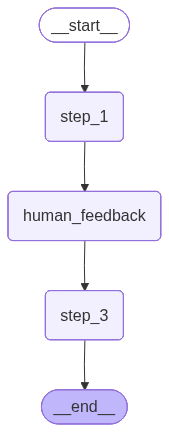

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

from langgraph.types import Command, interrupt


class State(TypedDict):
    input: str
    user_feedback: str


def step_1(state):
    print("---Step 1---")
    pass


def human_feedback(state):
    print("---human_feedback---")

    feedback = interrupt({"Please provide feedback:": "WAITING to Start"}) #we can pass any data structure here

    print("\n\n[GOT BACK FROM HUMAN AFTER INTERRUPT:]\n\n", feedback)
    return {"user_feedback": feedback}


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)

builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Input
initial_input = {"input": "hello we are learning interrupt"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

# State Get
# State Update
# Continue

---Step 1---
{'step_1': None}


---human_feedback---
{'__interrupt__': (Interrupt(value={'Please provide feedback:': 'WAITING to Start'}, id='a3ccfdf77736a44038bba92fe875989f'),)}




In [ ]:
# HOW TO RESUME
# Continue the graph execution
for event in graph.stream(
    Command(resume="Requesting to Start"),  #we can pass any data structure here too
    thread,
    stream_mode="updates"
):
    print(event)
    print("\n")

---human_feedback---


[GOT BACK FROM HUMAN AFTER INTERRUPT:]

 Requesting to Start
{'human_feedback': {'user_feedback': 'Requesting to Start'}}


---Step 3---
{'step_3': None}




In [ ]:
graph.get_state(thread).values

{'input': 'hello we are learning interrupt',
 'user_feedback': 'Requesting to Start'}

## Case 1: Approve or Reject

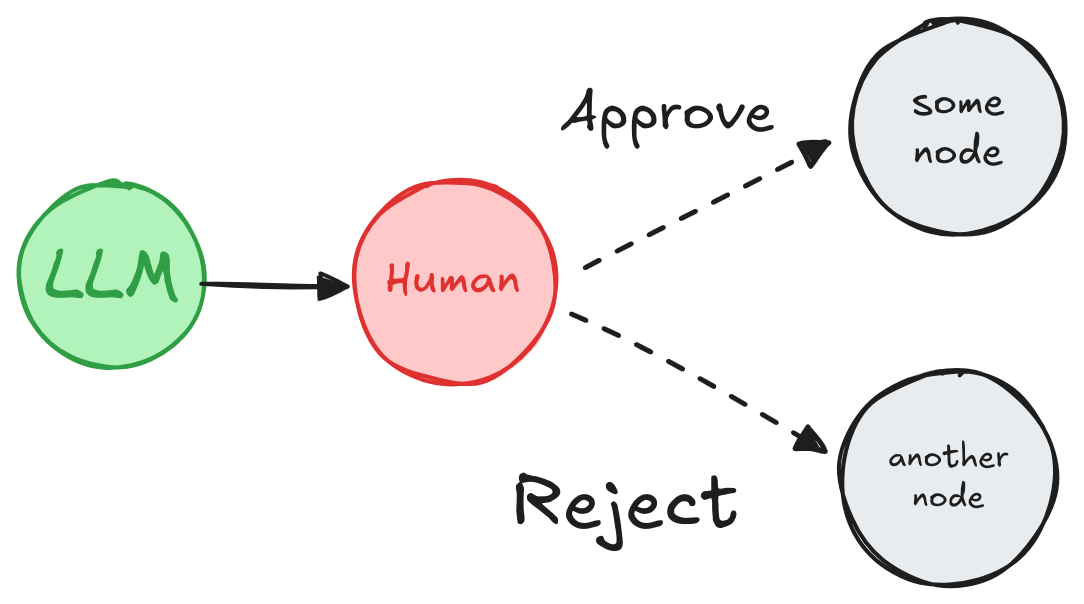

**Depending on the human's approval or rejection, the graph can proceed with the action or take an alternative path.**

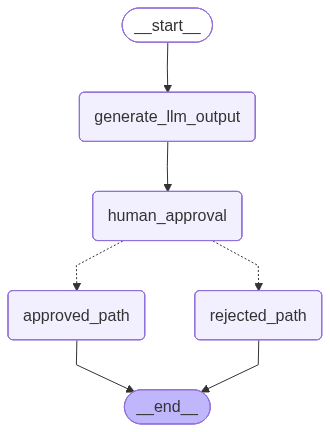

In [5]:
from IPython.display import Image, display
from typing import Literal, TypedDict
import uuid
from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver

# Define the shared graph state
class State(TypedDict):
    llm_output: str
    decision: str

# Simulate an LLM output node
def generate_llm_output(state: State) -> State:
    return {"llm_output": "This is the generated output."}

# Human approval node
def human_approval(state: State) -> Command[Literal["approved_path", "rejected_path"]]:
    decision = interrupt({
        "question": "Do you approve the following output?",
        "llm_output": state["llm_output"]
    })

    if decision == "approve":
        return Command(goto="approved_path", update={"decision": "approved"})
    else:
        return Command(goto="rejected_path", update={"decision": "rejected"})

# Next steps after approval
def approved_node(state: State) -> State:
    print("✅ Approved path taken.")
    return state

# Alternative path after rejection
def rejected_node(state: State) -> State:
    print("❌ Rejected path taken.")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("generate_llm_output", generate_llm_output)
builder.add_node("human_approval", human_approval)
builder.add_node("approved_path", approved_node)
builder.add_node("rejected_path", rejected_node)

builder.set_entry_point("generate_llm_output")
builder.add_edge("generate_llm_output", "human_approval")
builder.add_edge("approved_path", END)
builder.add_edge("rejected_path", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# Run until interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}


result = graph.invoke({}, config=config)
print(result["__interrupt__"])

# Using stream
# for event in graph.stream({}, config=config, stream_mode="updates"):
#     print(event)
#     print("\n")

[Interrupt(value={'question': 'Do you approve the following output?', 'llm_output': 'This is the generated output.'}, id='d7f972f4793c72970b884cef1ea8a379')]


In [7]:
# Simulate resuming with human input
# To test rejection, replace resume="approve" with resume="reject"
final_result = graph.invoke(Command(resume="approve"), config=config)
print(final_result)


# Using stream
# for event in graph.stream(
#     Command(resume="approve"),
#     config=config,
#     stream_mode="updates"
# ):
#     print(event)
#     print("\n")

✅ Approved path taken.
{'llm_output': 'This is the generated output.', 'decision': 'approved'}


In [8]:
#Now let's check with rejected

config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)
print(result["__interrupt__"])

# Using stream
# for event in graph.stream({}, config=config, stream_mode="updates"):
#     print(event)
#     print("\n")

[Interrupt(value={'question': 'Do you approve the following output?', 'llm_output': 'This is the generated output.'}, id='b62765454ce063da5325edde14702dac')]


In [9]:
final_result = graph.invoke(Command(resume="rejected"), config=config)
print(final_result)


# Using stream
# for event in graph.stream(
#     Command(resume="rejected"),
#     config=config,
#     stream_mode="updates"
# ):
#     print(event)
#     print("\n")

❌ Rejected path taken.
{'llm_output': 'This is the generated output.', 'decision': 'rejected'}


## Case 2 Tool Calling - Review/Reject

https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#review-tool-calls

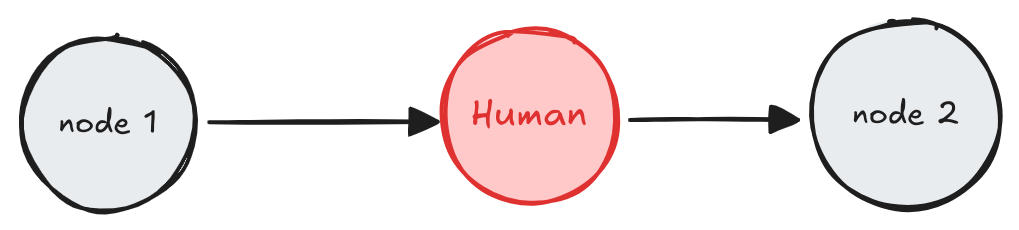

**A human can review and edit the state of the graph. This is useful for correcting mistakes or updating the state with additional information.**

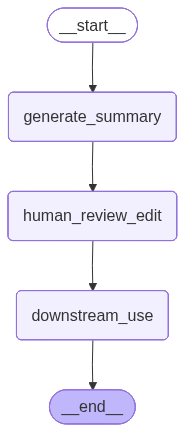

In [15]:
from typing import TypedDict
import uuid
from IPython.display import Image, display
from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver

# Define the graph state
class State(TypedDict):
    summary: str

# Simulate an LLM summary generation
def generate_summary(state: State) -> State:
    return {
        "summary": "The cat sat on the mat and looked at the stars."
    }

# Human editing node
def human_review_edit(state: State) -> State:
    result = interrupt({
        "task": "Please review and edit the generated summary if necessary.",
        "generated_summary": state["summary"]
    })
    return {
        "summary": result["edited_summary"]
    }

# Simulate downstream use of the edited summary
def downstream_use(state: State) -> State:
    print(f"✅ Using edited summary: {state['summary']}")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("generate_summary", generate_summary)
builder.add_node("human_review_edit", human_review_edit)
builder.add_node("downstream_use", downstream_use)

builder.set_entry_point("generate_summary")
builder.add_edge("generate_summary", "human_review_edit")
builder.add_edge("human_review_edit", "downstream_use")
builder.add_edge("downstream_use", END)

# Set up in-memory checkpointing for interrupt support
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)

# # Output interrupt payload
print(result["__interrupt__"])


[Interrupt(value={'task': 'Please review and edit the generated summary if necessary.', 'generated_summary': 'The cat sat on the mat and looked at the stars.'}, id='52124f1f3d47ccfb0c861b85386518c7')]


In [17]:
# Resume the graph with human-edited input
edited_summary = "The cat lay on the rug, gazing peacefully at the night sky."
resumed_result = graph.invoke(
    Command(resume={"edited_summary": edited_summary}),
    config=config
)
print(resumed_result)


✅ Using edited summary: The cat lay on the rug, gazing peacefully at the night sky.
{'summary': 'The cat lay on the rug, gazing peacefully at the night sky.'}


**Using stream**

In [18]:
# Using stream

config = {"configurable": {"thread_id": uuid.uuid4()}}

for event in graph.stream({}, config=config, stream_mode="updates"):
    print(event)
    print("\n")

{'generate_summary': {'summary': 'The cat sat on the mat and looked at the stars.'}}


{'__interrupt__': (Interrupt(value={'task': 'Please review and edit the generated summary if necessary.', 'generated_summary': 'The cat sat on the mat and looked at the stars.'}, id='82954b64f201289e4ebcbba416962905'),)}




In [19]:
# Using stream

edited_summary = "The cat lay on the rug, gazing peacefully at the night sky."

for event in graph.stream(
    Command(resume={"edited_summary": edited_summary}),
    config=config,
    stream_mode="updates"
):
    print(event)
    print("\n")

{'human_review_edit': {'summary': 'The cat lay on the rug, gazing peacefully at the night sky.'}}


✅ Using edited summary: The cat lay on the rug, gazing peacefully at the night sky.
{'downstream_use': {'summary': 'The cat lay on the rug, gazing peacefully at the night sky.'}}




**Case 2 Tool Calling - Review tool calls**


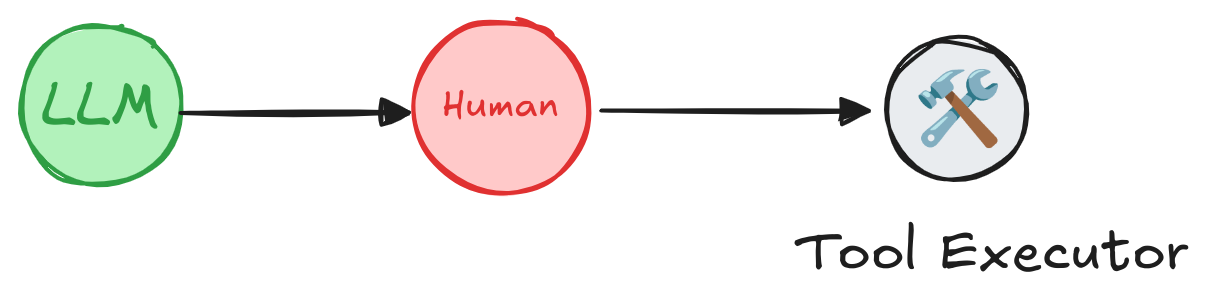

**A human can review and edit the output from the LLM before proceeding. This is particularly critical in applications where the tool calls requested by the LLM may be sensitive or require human oversight.**

In [ ]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import interrupt
from langgraph.prebuilt import create_react_agent

# An example of a sensitive tool that requires human review / approval
def book_hotel(hotel_name: str):
    """Book a hotel"""
    response = interrupt(
        f"Trying to call `book_hotel` with args {{'hotel_name': {hotel_name}}}. "
        "Please approve or suggest edits."
    )
    if response["type"] == "accept":
        pass
    elif response["type"] == "edit":
        hotel_name = response["args"]["hotel_name"]
    else:
        raise ValueError(f"Unknown response type: {response['type']}")
    return f"Successfully booked a stay at {hotel_name}."

checkpointer = InMemorySaver()

agent = create_react_agent(
    model="anthropic:claude-3-5-sonnet-latest",
    tools=[book_hotel],
    checkpointer=checkpointer,
)

In [ ]:
config = {
   "configurable": {
      "thread_id": "1"
   }
}

for chunk in agent.stream(
    {"messages": [{"role": "user", "content": "book a stay at McKittrick hotel"}]},
    config
):
    print(chunk)
    print("\n")

In [ ]:
from langgraph.types import Command

for chunk in agent.stream(
    Command(resume={"type": "accept"}),
    # Command(resume={"type": "edit", "args": {"hotel_name": "McKittrick Hotel"}}),
    config
):
    print(chunk)
    print("\n")